In [1]:
import numpy as np
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
class NeuralNetworkV0:
    
    def __init__(self, activation_dims):
        
        self.activation_dims = activation_dims
        self.layers = len(activation_dims)
        self.network = {}
        self.gradient = {}
        self.output = np.zeros(activation_dims[-1])
        self.create_network()
        
    def create_network(self):
        
        for layer in range(self.layers):
            self.network[layer+1] = {}
            
            if (layer+1 == 1):
  
                self.network[layer+1]["activations"] = self.sigmoid(np.empty(self.activation_dims[layer]).reshape(-1,1)) 
                
            else:
                self.network[layer+1]["activations"] = np.random.rand(self.activation_dims[layer]).reshape(-1,1)
                self.network[layer+1]["weights"] = np.random.uniform(-0.5, 0.5, size = self.activation_dims[layer]*self.activation_dims[layer-1]).reshape(self.activation_dims[layer], self.activation_dims[layer-1])
                self.network[layer+1]["biases"] = np.random.uniform(-0.5, 0.5, size = self.activation_dims[layer]).reshape(-1,1)
    
    def create_gradient(self):
        
        g = {}
        for layer in range(2, self.layers+1):
            g[layer] = {}
            
            g[layer]["weights"] = np.zeros(self.network[layer]["weights"].shape)
            g[layer]["biases"] = np.zeros(self.network[layer]["biases"].shape)

        return g
       
    def calculate_z(self, a, w, b):

        """caculate z from z = a*w + b"""

        return np.dot(w, a) + b

    def sigmoid(self, x):
    
        """return value of sigmoid function of x"""

        return 1/(1+np.exp(-x))

    def cost_function_derivative(self, a, y):
        
        """return value of the cost function derivative of a and y"""

        return 2*(a-y)

    def sigmoid_derivative(self, x):
        
        """reuturn value of sigmoid derivative of x"""

        return (1/(1+np.exp(-x))**2)*np.exp(-x)

    def forward(self, data, index):
        
        """calculate activations in each layer"""
        
        for layer in range(1, self.layers+1):
            
            if (layer == 1):
  
                # self.network[layer]["activations"] = self.sigmoid(data[index].reshape(-1,1))
                self.network[layer]["activations"] = (data[index].reshape(-1,1))/255
                
            else:
    
                self.network[layer]["activations"] = self.sigmoid(self.calculate_z(self.network[layer-1]["activations"], self.network[layer]["weights"], self.network[layer]["biases"]))

        return self.network[self.layers]["activations"]
        
    def back(self, l, g, e = None):

        """compute backpropagation and return gradient of the network"""
        
        n = self.network
        
        if (l == 1):
            return g
        else:
            z = self.calculate_z(n[l-1]["activations"], n[l]["weights"], n[l]["biases"])
            da_by_dz = self.sigmoid_derivative(z)

            if (l == len(n)):
                dc_by_da = self.cost_function_derivative(n[l]["activations"], e)
            else:
                dc_by_da = np.sum(g[l+1]["biases"]*n[l+1]["weights"], axis = 0).reshape(-1,1)
                # dc_by_da = np.dot(n[l+1]["weights"], g[l+1["biases"]])

            g[l]["weights"] = n[l-1]["activations"].reshape(-1)*dc_by_da*da_by_dz
            g[l]["biases"] = dc_by_da*da_by_dz
            g = self.back(l-1,g)
            return g

    
    def add_gradient(self, g1, g2):

        """return added gradient"""

        w = "weights"
        b = "biases"
        l = len(g1)
        
        for i in range(2, l+2, 1):
            g1[i][w] += g2[i][w]
            g1[i][b] += g2[i][b]

        return g1

    def average_gradient(self, g, batch_size):

        """averaging the gradient with batch size and return averaged gradient"""

        w = "weights"
        b = "biases"
        for i in range(2, self.layers + 1, 1):
            g[i][w]/=batch_size
            g[i][b]/=batch_size

        return g

    def graident_descent(self, g, lr):

        """compute graident descent"""
        
        w = "weights"
        b = "biases"
        for i in range(2, self.layers + 1, 1):
            self.network[i][w] -= lr*g[i][w]
            self.network[i][b] -= lr*g[i][b]
            
    
    def calculate_loss(self, pred, true):
        true_output = np.zeros(len(pred))
        true_output[true] = 1

        mse = ((true_output - pred.squeeze())**2).sum() / len(pred)

        return mse
        

In [3]:
n = NeuralNetworkV0([784, 32, 16, 10])

learning_rate = 0.005
epochs = 30
batch_size = 1
train_losses = []
test_losses = []
train_accs = []
test_accs = []

print("activation dimensions :", n.activation_dims)
print("learning rate :", learning_rate)
print("epochs :", epochs)
print("batch_size :", batch_size)

for i in range(epochs):
    print(f"Epoch: {i}\n------------")
    index = 0
    train_loss, train_acc = 0, 0
    for j in range(0, 60000, batch_size):
        
        n.gradient = n.create_gradient()

        for k in range(batch_size):
            
            logit = n.forward(x_train, index)
            expect_num = y_train[index]
            expect_output = np.zeros(10)
            expect_output[expect_num] = 1
            expect_output = expect_output.reshape((-1,1))
            n.gradient = n.add_gradient(n.gradient, n.back(l = n.layers, g = n.create_gradient(), e = expect_output))
            index += 1
            train_loss += n.calculate_loss(logit, expect_num)  
            train_acc += (expect_num==np.argmax(logit)).sum().item()

        n.gradient = n.average_gradient(n.gradient, batch_size)
        n.graident_descent(n.gradient, learning_rate)
        
    train_loss /= 60000
    train_acc /= 60000
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f"Train Loss: {train_loss}")
    print(f"Train Acc: {train_acc*100} %")
    index = 0
    correct = 0
    test_loss = 0

    for j in range(10000):
        test_logit = n.forward(x_test, index)
        expect_num = y_test[index]
        test_loss += n.calculate_loss(test_logit, expect_num)
        output = n.network[n.layers]["activations"]
        if(np.argmax(output) == expect_num):
            correct += 1
        index += 1
    test_loss /= 10000
    test_acc = (correct/index)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Test Loss: {test_loss}")
    print("Test accuracy: ", test_acc*100, "%")

activation dimensions : [784, 32, 16, 10]
learning rate : 0.005
epochs : 30
batch_size : 1
Epoch: 0
------------
Train Loss: 0.08125274657290225
Train Acc: 35.626666666666665 %
Test Loss: 0.061198802176596345
Test accuracy:  59.21999999999999 %
Epoch: 1
------------
Train Loss: 0.04527691736783542
Train Acc: 73.13666666666667 %
Test Loss: 0.03334571879187312
Test accuracy:  81.53 %
Epoch: 2
------------
Train Loss: 0.027016279025272438
Train Acc: 85.38333333333334 %
Test Loss: 0.021414029650036522
Test accuracy:  88.4 %
Epoch: 3
------------
Train Loss: 0.01946442047599867
Train Acc: 89.06500000000001 %
Test Loss: 0.0168973982008857
Test accuracy:  90.56 %
Epoch: 4
------------
Train Loss: 0.016127327626916
Train Acc: 90.57666666666667 %
Test Loss: 0.014630634721467667
Test accuracy:  91.47999999999999 %
Epoch: 5
------------
Train Loss: 0.014206655216953567
Train Acc: 91.58833333333334 %
Test Loss: 0.013230758554952152
Test accuracy:  92.15 %
Epoch: 6
------------
Train Loss: 0.012897

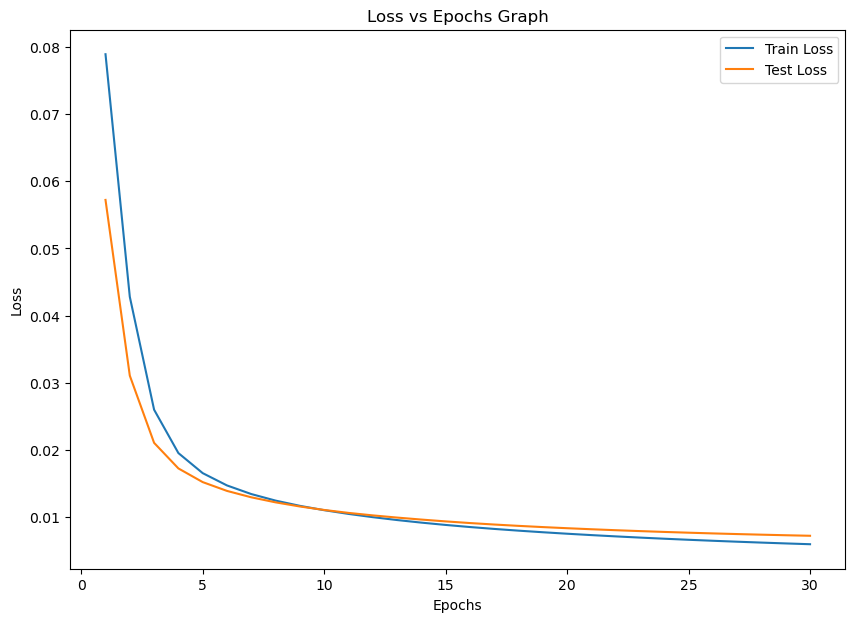

In [4]:
import matplotlib.pyplot as plt
epoch_list = [i for i in range(1, epochs+1)]
plt.figure(figsize=(10, 7))
plt.plot(epoch_list, train_losses, label="Train Loss")
plt.plot(epoch_list, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs Graph")
plt.legend()

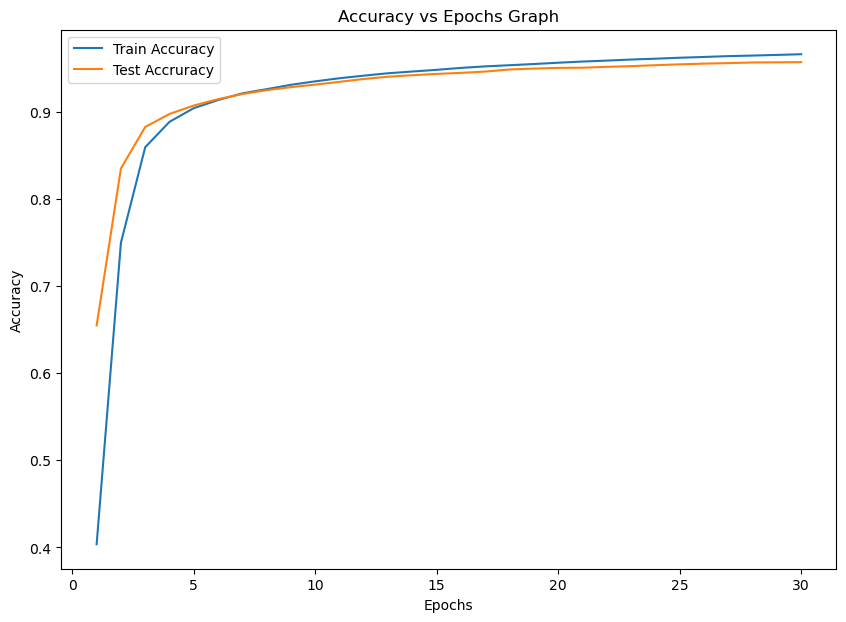

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(epoch_list, train_accs, label="Train Accuracy")
plt.plot(epoch_list, test_accs, label="Test Accruracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs Graph")
plt.legend()

Predict: 8
True Value: 8


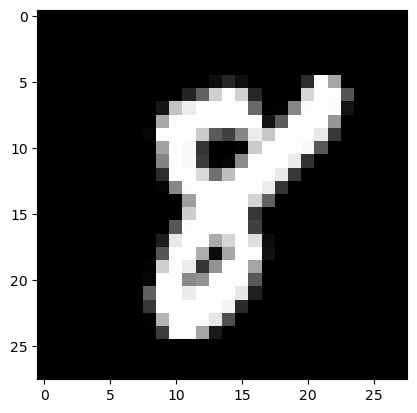

In [7]:
## Predict
num = np.random.randint(0, 10001)
plt.imshow(x_test[num], cmap="grey")
print(f"Predict: {np.argmax(n.forward(x_test, num))}")
print(f"True Value: {y_test[num]}")